In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 安裝pytorch 人臉辨識facenet套件

In [2]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.4 MB/s eta 0:00:00


## import 用到的套件

In [28]:
folder="/content/drive/MyDrive/解密AI黑盒子分享/"
import sys
sys.path.append(folder+"模組/")
import webcam2

In [29]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

## 初始化人臉檢測網路

In [75]:
mtcnn0 = MTCNN(image_size=240, margin=0, keep_all=False, min_face_size=40) # keep_all=False
mtcnn = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40) # keep_all=True
resnet = InceptionResnetV1(pretrained='vggface2').eval() 

In [126]:
dataset = datasets.ImageFolder("/content/drive/MyDrive/akw") # 讀取照片資料夾 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # 資料夾名稱轉人名連結
def collate_fn(x):
    return x[0]
loader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn)
name_list = [] #空的姓名列表
embedding_list = [] #空的特徵向量

for img, idx in loader:
    face, prob = mtcnn0(img, return_prob=True)
    if face is not None and prob>0.92:
        emb = resnet(face.unsqueeze(0)) 
        embedding_list.append(emb.detach()) 
        name_list.append(idx_to_class[idx])

#儲存訓練資料
data = [embedding_list, name_list] 
torch.save(data, '/content/drive/MyDrive/data.pt') # saving data.pt file

## 是否有GPU可以使用

In [127]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [128]:
load_data = torch.load('/content/drive/MyDrive/data.pt') 
embedding_list = load_data[0] 
name_list = load_data[1] 

In [ ]:
print(name_list)
print(embedding_list)

In [130]:
test_transform=transforms.ToTensor()

In [131]:
def test(route,sc=7):
  test_img = Image.open(route)
  img = test_transform(test_img) #目前的影像作預處裡
  img=transforms.ToPILImage()(img)
  img_cropped_list, prob_list = mtcnn(img, return_prob=True)
  if img_cropped_list is not None:
    boxes, _ = mtcnn.detect(img)
    for i, prob in enumerate(prob_list):
      if prob>0.90:
        emb = resnet(img_cropped_list[i].unsqueeze(0)).detach() 
        dist_list = [] # 儲存人臉特徵向量距離
        for idx, emb_db in enumerate(embedding_list):
          dist = torch.dist(emb, emb_db).item()
          dist_list.append(dist)
          min_dist = min(dist_list) # 得到最短距離，即最相似度
          min_dist_idx = dist_list.index(min_dist) #得到最短距離的索引
          Output = name_list[min_dist_idx] #得到最近的姓名
  print(Output)
  width, height = test_img.size
  return test_img.resize((width//sc,height//sc))


8


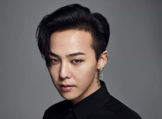

In [101]:
test("/content/GD.jpg",4)

8


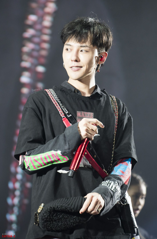

In [103]:
test("/content/GD.jfif")

8


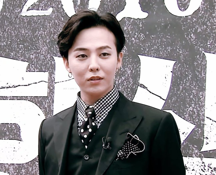

In [105]:
test("/content/GD2.jfif",5)

In [132]:
webcam2.video_stream()   #開始從webcam串流影像
count = 0
Starttime=time.time()
HTML=""         #影片上方要顯示的文字 
while True:
  img = webcam2.video_frame(HTML)          #取得目前的影像frame，傳入對應的圖片說明
  if not img:
    break
  img = test_transform(img) #目前的影像作預處裡
  img=transforms.ToPILImage()(img)
  img_cropped_list, prob_list = mtcnn(img, return_prob=True)
  if img_cropped_list is not None:
    boxes, _ = mtcnn.detect(img)
    for i, prob in enumerate(prob_list):
      if prob>0.90:
        emb = resnet(img_cropped_list[i].unsqueeze(0)).detach() 
        dist_list = [] # 儲存人臉特徵向量距離
        for idx, emb_db in enumerate(embedding_list):
          dist = torch.dist(emb, emb_db).item()
          dist_list.append(dist)
          min_dist = min(dist_list) # 得到最短距離，即最相似度
          min_dist_idx = dist_list.index(min_dist) #得到最短距離的索引
          Output = name_list[min_dist_idx] #得到最近的姓名
  count+=1
  Stoptime=time.time()
  HTML =str(round(count/(Stoptime-Starttime),2))+"FPS<br>"+Output

<IPython.core.display.Javascript object>